In [1]:
%matplotlib notebook
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

import traceback, functools, pprint, math, random

import pymunk
import pymunk.matplotlib_util
from pymunk.vec2d import Vec2d
from IPython.display import HTML

def print_errors_to_stdout(fun):
    @functools.wraps(fun)
    def wrapper(*args,**kw):
        try:
            return fun(*args,**kw)
        except Exception:
            traceback.print_exc()
            raise
    return wrapper

In [2]:
nx, ny = 501, 501

<IPython.core.display.Javascript object>


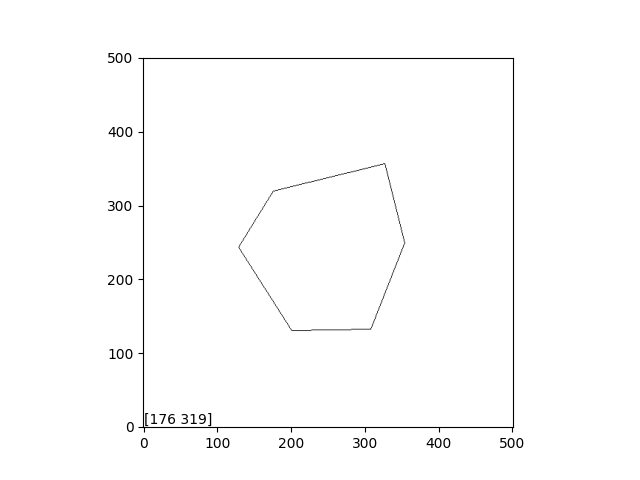

In [3]:
plt.figure()
img = np.full((nx, ny, 3), 255, dtype='uint8')

plt.ion()

im = plt.imshow(img, origin='lower')
fig = plt.gcf()
ax = plt.gca()

text=ax.text(0,0, "", va="bottom", ha="left")

points = np.array([], dtype='uint8').reshape((-1, 2))
snap_threshold = 10

@print_errors_to_stdout
def on_press(event):
    global points
    
    if plt.isinteractive():
        # debug printout
        # tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        # text.set_text(tx)

        x_coord, y_coord = int(event.xdata), int(event.ydata)
        point = np.array([x_coord, y_coord])
        
        if len(points) > 1 and all(np.abs(point - points[0]) < snap_threshold):
            point = points[0]
            plt.ioff()
        
        points = np.vstack((points, point))
        text.set_text(f'{point}')

        if len(points) > 1:
            n = len(points)
            cv2.line(img, tuple(points[n-2]), tuple(points[n-1]), (0, 0, 0), thickness=1)

        im.set_data(img)

        plt.draw()

@print_errors_to_stdout
def on_move(event):
    if plt.isinteractive() and event.inaxes is not None:
        tmp_img = np.copy(img)
        
        x_coord, y_coord = int(event.xdata), int(event.ydata)
        point = np.array([x_coord, y_coord])
        
        if len(points) >= 1:
            n = len(points)
            
            if all(np.abs(point - points[0]) < snap_threshold):
                point = points[0]
                
            cv2.line(tmp_img, tuple(points[n-1]), tuple(point), (0, 0, 0), thickness=1)
            
        im.set_data(tmp_img)

        plt.draw()
        
cid = fig.canvas.mpl_connect('button_press_event', on_press)
cid = fig.canvas.mpl_connect('motion_notify_event', on_move)

In [135]:
points = np.array([(-42, -41), (48, -41), (39, 25), (-34, 59)]) # 4gon in paper
# points = np.array([(-42, -41), (48, -41), (48, 40), (-42, 40)]) # Rectangular box
# points = np.array([(-42, -42), (42, -42), (42, 42), (-42, 42)]) # Square box
# points = np.array([(-25, -33), (25, -33), (25, 20), (0, 45), (-25, 20)]) # House shape
# points = np.array([[233, 360], [131, 268], [147, 164], [243, 123], [318, 300], [245, 292], [233, 360]]) # another test shape
# points = np.array([[-37,  21], [-42, -20], [ 11, -52], [ 36,   7], [ 42,  48]], dtype=np.int32)

In [4]:
def centroid(points):
    """Returns the centroid of a polygon"""
    n = len(points)
    def next(i):
        return (i + 1) % n
    shoelace = [points[i, 0]*points[next(i), 1] - points[next(i), 0]*points[i, 1] for i in range(n)]
    list_x = [(points[i, 0] + points[next(i), 0])*shoelace[i] for i in range(n)]
    list_y = [(points[i, 1] + points[next(i), 1])*shoelace[i] for i in range(n)]
    
    const = 1/(6*polygon_signed_area(points))
    C_x = const * sum(list_x)
    C_y = const * sum(list_y)
    
    return C_x, C_y
    
def polygon_signed_area(points):
    """Returns the signed area of a polygon as described by the shoelace formula"""
    n = len(points)
    def next(i):
        return (i + 1) % n
    
    res = sum([points[i, 0]*points[next(i), 1] - points[next(i), 0]*points[i, 1] for i in range(n)])
    return res/2

def scale_polygon(points):
    """Scales the polygon so that the largest dimension is approximately 100 units"""
    width = max(points[:, 0]) - min(points[:, 0])
    height = max(points[:, 1]) - min(points[:, 1])
    
    larger = max(width, height)
    scale = 100/larger
    
    return np.around(points * scale).astype(np.int32)

def scale_and_center_polygon(points):
    points = scale_polygon(points)

    C_x, C_y = centroid(points)

    points[:, 0] -= round(C_x)
    points[:, 1] -= round(C_y)
    
    return points

In [5]:
points = scale_and_center_polygon(points[:-1])
# points = scale_and_center_polygon(points)
points

array([[-33,  35],
       [-54,   2],
       [-22, -48],
       [ 25, -48],
       [ 46,   4],
       [ 34,  52]], dtype=int32)

<IPython.core.display.Javascript object>


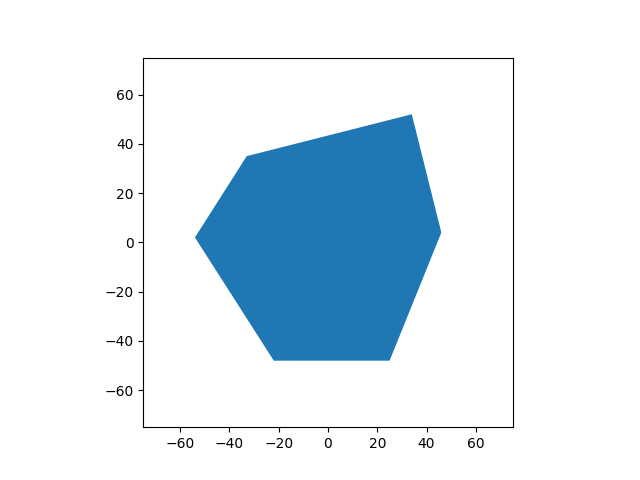

In [6]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.gca().set_aspect("equal")
plt.xlim((-75, 75))
plt.ylim((-75, 75))
plt.show()

[[-33 -54 -22  25  46  34]
 [ 35   2 -48 -48   4  52]]


<IPython.core.display.Javascript object>


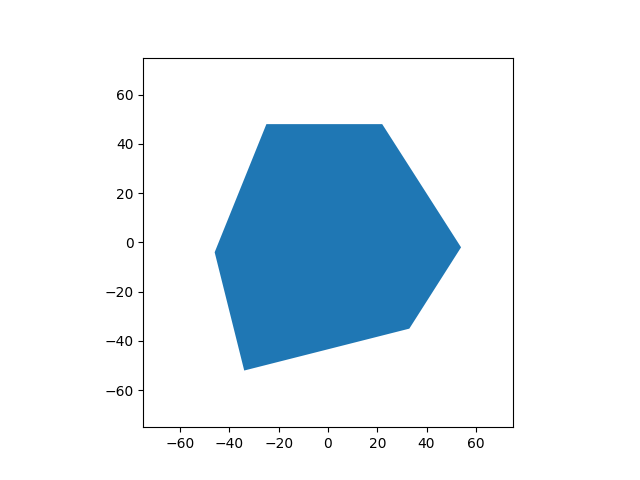

In [10]:
theta = np.pi
print(points.T)

s, c = np.sin(theta), np.cos(theta)
matrix = np.array([[c, -s],
                  [s, c]])

points_rotated = np.dot(matrix, points.T)

plt.figure()
plt.fill(points_rotated[0], points_rotated[1])
plt.gca().set_aspect("equal")
plt.xlim((-75, 75))
plt.ylim((-75, 75))
plt.show()

In [11]:
def signed_area(p1, p2, p3):
    """
    Returns the twice the signed area of a triangle defined by the points (p1, p2, p3).
    The sign is positive if and only if (p1, p2, p3) form a counterclockwise cycle
    (a left turn). If the points are colinear, then this returns 0. If the points form
    a clockwise cycle, this returns a negative value.
    
    This method is described in further detail in Preparata and Shamos (1985). 
    """
    mat = np.hstack((np.vstack((p1, p2, p3)), np.ones((3, 1)))).astype('int32')
    return round(np.linalg.det(mat)) # since matrix only has integers, determinant should itself be an integer

def convex_hull(points):
    """
    Returns the convex hull of a set of points, which defines a convex polygon. 
    The returned points form a counterclockwise sequence.
    
    This is an implementation of Jarvis's march algorithm, which runs in O(nh) time.
    """
    assert len(points) >= 3
    
    l_idx = np.argmin(points, axis=0)[0]
    l = points[l_idx]
    
    result = [l]
    start = 0
    
    p, q = l_idx, None
    while True:
        q = (p + 1) % len(points)
        
        for i in range(len(points)):
            if i == p:
                continue
            v1, v2 = points[i]-points[p], points[q]-points[i]
            d = signed_area(points[p], points[i], points[q])
            if d > 0 or (d == 0 and np.linalg.norm(v1) > np.linalg.norm(v2)):
                q = i
                
        p = q
        if p == l_idx:
            break
        result.append(points[q])
        
    return np.array(result)

# ch = convex_hull(points[:-1])
ch = convex_hull(points)

<IPython.core.display.Javascript object>


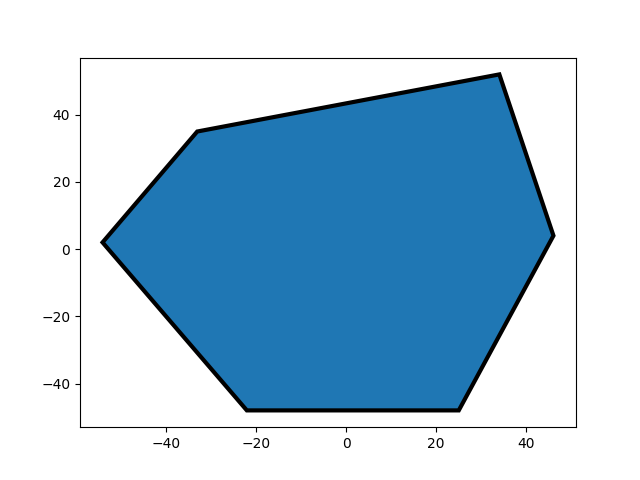

In [12]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='black', linewidth=3)
plt.show()

In [13]:
def antipodal_pairs(points):
    """
    Returns the antipodal pairs of a convex polygon. The points must be in
    a counterclockwise sequence.
    
    This procedure is described in further detail in Preparata and Shamos (1985).
    """
    res = []
    piecewise_diameter = []
    n = len(points)
    def _next(i):
        return (i + 1) % n
    def previous(i):
        return (i - 1) % n
    
    p = n - 1
    q = _next(p)
    while signed_area(points[p], points[_next(p)], points[_next(q)]) > \
          signed_area(points[p], points[_next(p)], points[q]):
        q = _next(q)
        
    p0, q0 = 0, q

    while q != p0:
        p = _next(p)
        res.append((p, q))
        
        p1, p2 = points[p], points[q]
        initial_angle = get_angle(points[previous(p)], points[p])
        chord_length = np.linalg.norm(p2-p1)
        angle_max_length = get_angle(p1, p2) + np.pi/2
        print(p1, p2, initial_angle, angle_max_length)
        
        piecewise_diameter.append((initial_angle, chord_length, angle_max_length))
        
        while signed_area(points[p], points[_next(p)], points[_next(q)]) > \
              signed_area(points[p], points[_next(p)], points[q]):
            q = _next(q)
            
            # add to piecewise diameter function
            if (p, q) != (q0, p0):
                p1, p2 = points[p], points[q]
                initial_angle = get_angle(points[q], points[previous(q)])
                chord_length = np.linalg.norm(p2-p1)
                angle_max_length = get_angle(p1, p2) + np.pi/2
                print(p1, p2, initial_angle, angle_max_length)
                
                piecewise_diameter.append((initial_angle, chord_length, angle_max_length))
                res.append((p, q))
            else:
                break
        if signed_area(points[p], points[_next(p)], points[_next(q)]) == \
           signed_area(points[p], points[_next(p)], points[q]):
            # TODO handle parallel edges
            print('parallel', [points[p],points[_next(q)], [p, _next(q)]])
            if (p, q) != (q0, n-1):
                res.append((p, _next(q)))
            else:
                break
                        
    return np.array(res), piecewise_diameter

def get_angle(p1, p2):
    """Returns the angle of the vector from p1 to p2"""
    v = p2 - p1
    return np.arctan2(*v[::-1]) # % np.pi

[-54   2] [ 25 -48] -2.137525544318403 1.0065281379369648
[-54   2] [46  4] -1.9546139500834654 1.590793660768047
[-54   2] [34 52] -1.3258176636680326 2.0874914655571737
[-22 -48] [34 52] -1.0014831356942346 2.6311043316730176
[ 25 -48] [34 52] 0.0 3.051834479399843
[ 25 -48] [-33  35] 0.24848742065740273 3.7515095566668606


<IPython.core.display.Javascript object>


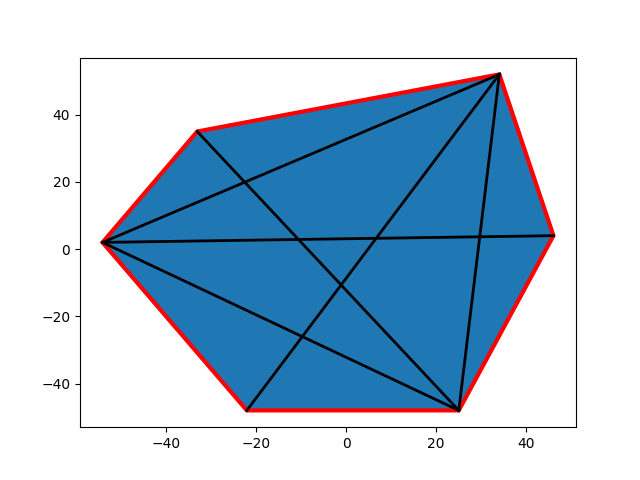

In [14]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='red', linewidth=3)
for p1, p2 in antipodal_pairs(ch)[0]:
    x1, y1 = ch[p1]
    x2, y2 = ch[p2]
    plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
plt.show()

[-54   2] [ 25 -48] -2.137525544318403 1.0065281379369648
[-54   2] [46  4] -1.9546139500834654 1.590793660768047
[-54   2] [34 52] -1.3258176636680326 2.0874914655571737
[-22 -48] [34 52] -1.0014831356942346 2.6311043316730176
[ 25 -48] [34 52] 0.0 3.051834479399843
[ 25 -48] [-33  35] 0.24848742065740273 3.7515095566668606


<IPython.core.display.Javascript object>


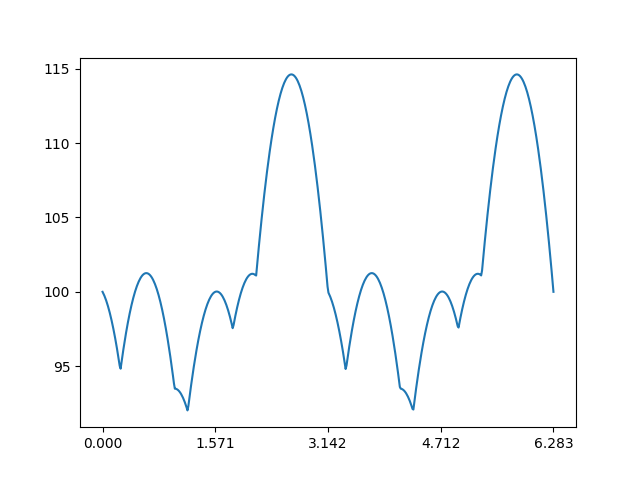

In [15]:
piecewise_diameter = antipodal_pairs(ch)[1]

def generate_range(piecewise_func, period, domain=(0, 2*np.pi)):
    while piecewise_func[0][0] >= domain[0]:
        shift = [(p[0] - period,) + p[1:] for p in piecewise_func]
        piecewise_func = shift + piecewise_func
        
    while piecewise_func[len(piecewise_func) - 1][0] <= domain[1]:
        shift = [(p[0] + period,) + p[1:] for p in piecewise_func]
        piecewise_func = piecewise_func + shift
    
    return piecewise_func

def generate_func(piecewise_func):
    """Convenience function to generate a callable piecewise function based off piecewise_func"""
    
    def func(theta):
        for i in range(0, len(piecewise_func)-1):
            if piecewise_func[i][0] <= theta < piecewise_func[i+1][0]:
                return piecewise_func[i][1] * abs(math.cos(theta-piecewise_func[i][2]))
            
    return func
diameter_func = generate_func(generate_range(piecewise_diameter, np.pi))

x = np.linspace(0, 2*np.pi, 500)
y = np.array([diameter_func(t) for t in x])

plt.figure()
plt.plot(x, y)
plt.xticks(np.linspace(0, 2*np.pi, 5))
plt.show()

In [16]:
def plot_angle(point, angle, length=50, color='k', **kwargs):
    slope = np.tan(angle)
    plot_slope(point, slope, length, color)
    
def plot_slope(point, slope, length=50, color='k', **kwargs):
    length = length / 2
    x, y = point
    l = math.sqrt(length**2/(slope**2+1))
    plt.plot([x-l, x+l], [y-l*slope, y+l*slope], color=color, linestyle='-', linewidth=2)

[-54   2] [ 25 -48] -2.137525544318403 1.0065281379369648
[-54   2] [46  4] -1.9546139500834654 1.590793660768047
[-54   2] [34 52] -1.3258176636680326 2.0874914655571737
[-22 -48] [34 52] -1.0014831356942346 2.6311043316730176
[ 25 -48] [34 52] 0.0 3.051834479399843
[ 25 -48] [-33  35] 0.24848742065740273 3.7515095566668606
Angle of perpendicular line from [-54   2] to [ 25 -48]: 1.0065281379369648
2.1401095178955587 1.0040671092713902
1.1869787035063277 0.0
Maximum angle of parallel supporting lines: 1.1869787035063277, modulo pi: 1.1869787035063277
Angle of perpendicular line from [-54   2] to [46  4]: 1.590793660768047
2.1401095178955587 1.0040671092713902
1.8157749899217608 1.1869787035063277
Maximum angle of parallel supporting lines: 1.8157749899217608, modulo pi: 1.8157749899217608
Angle of perpendicular line from [-54   2] to [34 52]: 2.0874914655571737
2.1401095178955587 1.0040671092713902
-2.8931052329323905 1.8157749899217608
Maximum angle of parallel supporting lines: -2.8

<IPython.core.display.Javascript object>


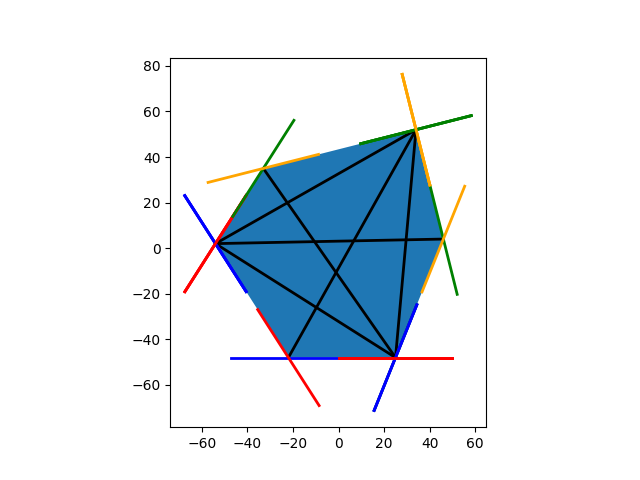

In [17]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
# plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='black', linewidth=3)

n = len(ch)
pairs = antipodal_pairs(ch)[0]

for p1, p2 in pairs:
    x1, y1 = ch[p1]
    x2, y2 = ch[p2]
    plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    
    v = ch[p2] - ch[p1]
    angle = np.arctan(v[1]/v[0] if v[0] != 0 else np.sign(v[1]) * np.inf) + np.pi/2
    print(f'Angle of perpendicular line from {ch[p1]} to {ch[p2]}: {angle}')
    
    v1, v2 = ch[p1] - ch[(p1+1)%n], ch[(p1-1)%n] - ch[p1]
    v3, v4 = ch[(p2+1)%n] - ch[p2], ch[p2] - ch[(p2-1)%n]
    
#     a1, a2 = np.arctan2(*v1[::-1]) % (2*np.pi), np.arctan2(*v2[::-1]) 
#     a3, a4 = np.arctan2(*v3[::-1]) % (2*np.pi), np.arctan2(*v4[::-1]) 
    
    a1, a2 = np.arctan2(*v1[::-1]), np.arctan2(*v2[::-1]) 
    a3, a4 = np.arctan2(*v3[::-1]), np.arctan2(*v4[::-1]) 
    print(a1, a2)
    print(a3, a4)
    # print(f'Range of movement of parallel supporting lines: [{max(a2, a4)}, {min(a1, a3)})')
    print(f'Maximum angle of parallel supporting lines: {min(a1, a3)}, modulo pi: {min(a1, a3) % np.pi}')
    plot_angle(ch[p1], a1, color='b', length=50)
    plot_angle(ch[p1], a2, color='r', length=50)
    plot_angle(ch[p2], a3, color='g', length=50)
    plot_angle(ch[p2], a4, color='orange', length=50)
    #slope = -1/(v[1]/v[0])
    
    #plot_angle(ch[p1], angle)
    #plot_angle(ch[p2], angle)

plt.gca().set_aspect(aspect='equal')
plt.show()

In [18]:
def make_diameter_function(convex_hull):
    """Returns a diameter function of a convex polygon"""
    pairs = antipodal_pairs(convex_hull)[0]
    
    pieces = []
    n = len(convex_hull)
    for p1, p2 in pairs:
        v = convex_hull[p2] - convex_hull[p1]  # vector from p1 to p2
        
        v1, v2 = convex_hull[p1] - convex_hull[(p1+1)%n], convex_hull[(p1-1)%n] - convex_hull[p1]
        v3, v4 = convex_hull[(p2+1)%n] - convex_hull[p2], convex_hull[p2] - convex_hull[(p2-1)%n]

        a1, a2 = np.arctan2(*v1[::-1]) % (2*np.pi), np.arctan2(*v2[::-1]) 
        a3, a4 = np.arctan2(*v3[::-1]) % (2*np.pi), np.arctan2(*v4[::-1]) 
        
        max_angle = min(a1, a3) % np.pi
        length = np.linalg.norm(v)  # length of the vector (chord)
        initial_angle = np.arctan(v[1]/v[0] if v[0] != 0 else np.sign(v[1]) * np.inf) + np.pi/2  # angle of the parallel supporting 
                                                        # lines that are perpendicular to the chord
        pieces.append((max_angle, length, initial_angle))
        
    pprint.pprint(pieces)
    piecewise_func = []
    for i in range(len(pieces)):
        min_ = pieces[(i-1) % len(pieces)][0]
        max_ = pieces[i][0]
        if max_ < min_:
            # wrapped around
            piecewise_func.append((min_, np.pi) + pieces[i][1:])
            piecewise_func.append((0, max_) + pieces[i][1:])
        else:
            piecewise_func.append((min_, max_) + pieces[i][1:])
        
    # remove parallel edges
    piecewise_func = sorted([p for p in piecewise_func if not np.isclose(p[0], p[1])], key=lambda x: x[0])
    
    def diameter_func(theta):
        theta = theta % np.pi
        for p in piecewise_func:
            min_, max_, l, i = p
            if min_ <= theta < max_:
                return l * np.abs(np.cos(theta-i))
        
    return np.array(piecewise_func), diameter_func

In [19]:
def find_extrema(piecewise_func, diameter_func):
    maxima = []
    for p in piecewise_func:
        min_, max_, l, i = p
        if min_ <= i < max_:
            maxima.append(i)
            maxima.append(i+np.pi)
    maxima.sort()
    ranges = [0] + maxima + [2*np.pi]
    
    minima = []
    discont = np.append(piecewise_func[:, :2].flatten(), piecewise_func[:, :2].flatten()+np.pi)
    for i in range(len(ranges)-1):
        valid_points = discont[np.logical_and(ranges[i] <= discont, discont <= ranges[i+1])]
        minimum = min(valid_points, key=diameter_func)
        
        minima.append(minimum)
        # minima.append(minimum+np.pi)
        
    return np.array(maxima), np.array(minima)

[-54   2] [ 25 -48] -2.137525544318403 1.0065281379369648
[-54   2] [46  4] -1.9546139500834654 1.590793660768047
[-54   2] [34 52] -1.3258176636680326 2.0874914655571737
[-22 -48] [34 52] -1.0014831356942346 2.6311043316730176
[ 25 -48] [34 52] 0.0 3.051834479399843
[ 25 -48] [-33  35] 0.24848742065740273 3.7515095566668606
[(1.1869787035063277, 93.49331526906082, 1.0065281379369648),
 (1.8157749899217608, 100.0199980003999, 1.590793660768047),
 (2.1401095178955587, 101.21264743103995, 2.0874914655571737),
 (0.0, 114.61239025515522, 2.6311043316730176),
 (0.2484874206574026, 100.40418317978589, 3.051834479399843),
 (1.0040671092713902, 101.25709851659784, 0.6099169030770673)]


<IPython.core.display.Javascript object>


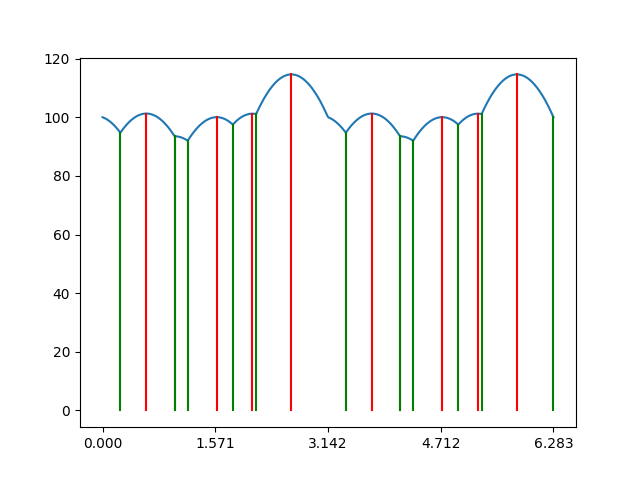

In [20]:
piecewise_func, diameter_func = make_diameter_function(ch)

x = np.linspace(0, 2*np.pi, 500)
y = np.array([diameter_func(t) for t in x])

plt.figure()
plt.plot(x, y)
plt.xticks(np.linspace(0, 2*np.pi, 5))

maxima, minima = find_extrema(piecewise_func, diameter_func)

for m in maxima:
    plt.plot([m, m], [0, diameter_func(m)], color='r')
for m in minima:
    plt.plot([m, m], [0, diameter_func(m)], color='g')

plt.show()

In [21]:
minima, maxima

(array([0.24848742, 1.00406711, 1.1869787 , 1.81577499, 2.14010952,
        3.39008007, 4.14565976, 4.32857136, 4.95736764, 5.28170217,
        6.28318531]),
 array([0.6099169 , 1.00652814, 1.59079366, 2.08749147, 2.63110433,
        3.75150956, 4.14812079, 4.73238631, 5.22908412, 5.77269699]))

In [22]:
def make_squeeze_func(piecewise_func, diameter_func):
    maxima, minima = find_extrema(piecewise_func, diameter_func)
    
    ranges = np.concatenate(([0], maxima, [2*np.pi]))
    def squeeze_func(theta):
        theta = theta % (2*np.pi)
        for i in range(len(ranges)-1):
            if ranges[i] <= theta < ranges[i+1]:
                assert ranges[i] <= minima[i] <= ranges[i+1]
                return minima[i]
            
        return 2*np.pi
    
    return squeeze_func

class SInterval:
    def __init__(self, a, b, image_min, image_max):
        assert a <= b
        assert image_min <= image_max or np.isclose(image_min, image_max)
        
        self.a = a
        self.b = b
        self.image_min = image_min
        self.image_max = image_max
        
        self.interval_m = self.b - self.a
        self.image_m = self.image_max - self.image_min
        
    def __repr__(self):
        return f'SInterval({round(self.a, 3)}, {round(self.b, 3)}, {round(self.image_min, 3)}, {round(self.image_max, 3)}, ' + \
               f'{round(self.interval_m, 3)}, {round(self.image_m, 3)})'

<IPython.core.display.Javascript object>


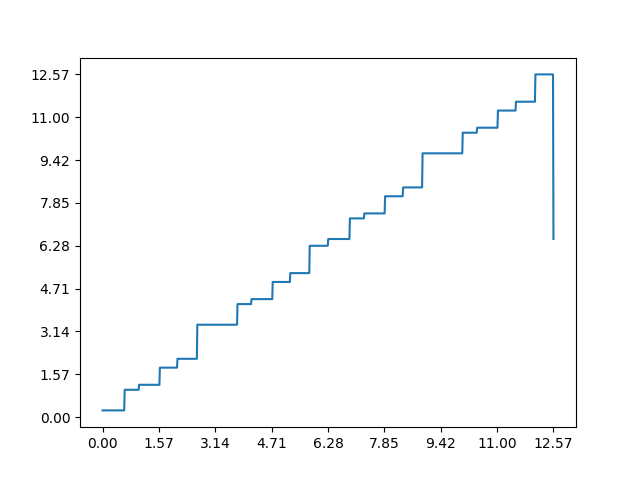

In [23]:
squeeze_func = make_squeeze_func(piecewise_func, diameter_func)

x = np.linspace(0, 4*np.pi, 1000)
y = np.array([squeeze_func(t) if t < 2*np.pi else squeeze_func(t) + 2*np.pi for t in x])

plt.figure()
plt.plot(x, y)
plt.xticks(np.linspace(0, 4*np.pi, 9))
plt.yticks(np.linspace(0, 4*np.pi, 9))
plt.show()

In [28]:
def period_from_r_fold(r):
    """
    Returns the period of a polygon's squeeze function given the n-fold (called r-fold in the paper) 
    rotational symmetry of the polygon
    """
    return 2*np.pi/(r*(1+r%2))


def detect_squeeze_periodicity(max_r=8):
    assert max_r >= 2, "All polygons have at least 1-fold rotational symmetry"
    
    res_r, res_T = 1, np.pi
    
    x = np.linspace(0, 2*np.pi, 1000)
    y = np.array([squeeze_func(t) for t in x])
    for r in range(2, max_r+1):
        T = period_from_r_fold(r)
        
        x_shift = x + T
        y_shift = np.array([squeeze_func(t) for t in x_shift]) % (2*np.pi)
        
        if all(np.isclose((y+T)%(2*np.pi), y_shift)):
            res_r, res_T = r, T
            
    return res_r, res_T

r, T = detect_squeeze_periodicity()
r, T

(1, 3.141592653589793)

In [29]:
s_intervals = []

max_single_step = SInterval(0, 0, 0, 0)
ranges = np.concatenate(([0], maxima, [2*np.pi]))
for i in range(len(ranges)-1):
    curr = ranges[i+1] - ranges[i]
    max_r = max_single_step.b - max_single_step.a
    if curr > max_r and not np.isclose(curr, max_r):
        max_single_step = SInterval(ranges[i], ranges[i+1], minima[i], minima[i])
        
s_intervals.append(max_single_step)

print(max_single_step)

all_s_intervals = []
for i in range(len(ranges)-1):
    for j in range(i+1, len(ranges)):
        if not np.isclose(minima[i], minima[j-1]):
            all_s_intervals.append(SInterval(ranges[i], ranges[j], minima[i], minima[j-1]))


def compare_interval(s1, s2):
    if not np.isclose(s1.image_m, s2.image_m):
        return s1.image_m - s2.image_m
    elif not np.isclose(s1.interval_m, s2.interval_m):
        return s1.interval_m - s2.interval_m
    return 0

def compare_interval2(s1, s2):
    s1 = all_s_intervals[s1]
    s2 = all_s_intervals[s2]
    if not np.isclose(s1.interval_m, s2.interval_m):
        return s2.interval_m - s1.interval_m
    elif not np.isclose(s1.a, s2.a):
        return s1.a - s2.a
    return 0

all_s_intervals.sort(key=functools.cmp_to_key(compare_interval))

while any(map(lambda s: s.image_m < s_intervals[len(s_intervals)-1].interval_m, all_s_intervals)):
    valid_ints = []
    idx = 0
    while idx < len(all_s_intervals) and \
          all_s_intervals[idx].image_m < s_intervals[len(s_intervals)-1].interval_m and \
          not np.isclose(all_s_intervals[idx].image_m, s_intervals[len(s_intervals)-1].interval_m):
        valid_ints.append(idx)
        idx += 1

    valid_ints.sort(key=functools.cmp_to_key(compare_interval2)) 
    
    # pprint.pprint([all_s_intervals[i] for i in valid_ints])
    
    n = all_s_intervals.pop(valid_ints[0])
    s_intervals.append(n)
    if np.isclose(n.interval_m, T): # or len(s_intervals) >= len(points)-1:
        break
    
s_intervals

SInterval(2.631, 3.752, 3.39, 3.39, 1.12, 0.0)


[SInterval(2.631, 3.752, 3.39, 3.39, 1.12, 0.0),
 SInterval(2.631, 4.732, 3.39, 4.329, 2.101, 0.938),
 SInterval(2.631, 5.773, 3.39, 5.282, 3.142, 1.892)]

In [30]:
plan = [0]

for i in reversed(range(len(s_intervals)-1)):
    eps = .5*(s_intervals[i].interval_m - s_intervals[i+1].image_m)
    alpha = s_intervals[i+1].image_min - s_intervals[i].a - eps + plan[len(plan)-1]
    plan.append(alpha)
    
plan

[0, 0.6541457998508446, 1.3221645713525638]

<IPython.core.display.Javascript object>


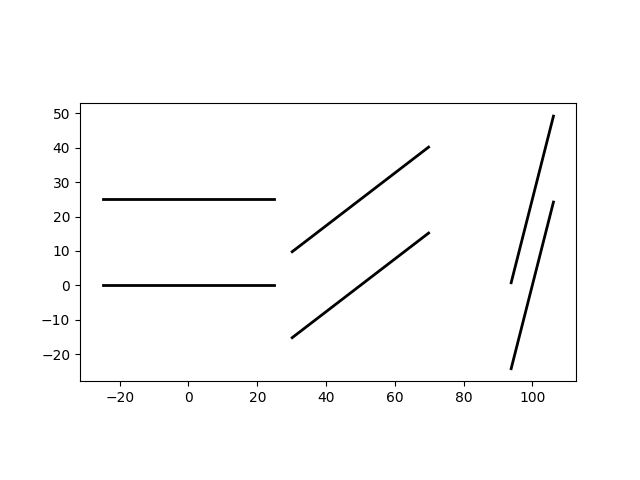

In [31]:
plt.figure()
plt.gca().set_aspect('equal')
for p, x in zip(plan, range(0, len(plan)*50, 50)):
    plot_angle((x, 25), p)
    plot_angle((x, 0), p)
    
plt.show()

In [89]:
class Gripper:
    
    filter = pymunk.ShapeFilter(categories=0b01, mask=0b10)
    
    def __init__(self, x, y, angle, distance=200, length=200, velocity=50):
        # computing slope, slope of perpendicular
        self.angle = angle
        self.slope = math.tan(angle)
        self.orth_slope = -1/self.slope if not np.isclose(0, self.slope) else -math.inf
        length, distance = length / 2, distance / 2
        
        if math.isfinite(self.orth_slope):
            # starting position offsets
            self.x_offset = distance/math.sqrt(self.orth_slope**2+1)
            self.y_offset = (self.orth_slope*distance)/math.sqrt(self.orth_slope**2+1)

            # squeeze velocity components, magnitude of velocity vector = velocity
            self.vel_x = velocity/math.sqrt(self.orth_slope**2+1)
            self.vel_y = velocity*self.orth_slope/math.sqrt(self.orth_slope**2+1)
        else:
            self.x_offset = 0
            self.y_offset = distance
            
            self.vel_x = 0
            self.vel_y = velocity
        
        # bottom gripper
        self.bot_vel = Vec2d(self.vel_x, self.vel_y) # squeeze velocity vector
        self.bot_pos = Vec2d(x-self.x_offset, y-self.y_offset) # starting position vector
        self.bot_limiter = Gripper.make_unsqueeze_limiter(self.bot_pos)
        
        self.bot = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        self.bot.position = self.bot_pos
        self.bot_seg = pymunk.Segment(self.bot, a=(-length, 0), b=(length, 0), radius=2)
        self.bot_seg.friction = 0
        self.bot_seg.elasticity = 0
        self.bot_seg.filter = Gripper.filter
        self.bot.angle = angle
        
        # top gripper
        self.top_vel = -Vec2d(self.vel_x, self.vel_y) # squeeze velocity vector
        self.top_pos = Vec2d(x+self.x_offset, y+self.y_offset) # starting position vector
        self.top_limiter = Gripper.make_unsqueeze_limiter(self.top_pos)
        
        self.top = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        self.top.position = self.top_pos
        self.top_seg = pymunk.Segment(self.top, a=(-length, 0), b=(length, 0), radius=2)
        self.top_seg.friction = 0
        self.top_seg.elasticity = 0
        self.top_seg.filter = Gripper.filter
        self.top.angle = angle
    
    @staticmethod
    def make_unsqueeze_limiter(pos, eps=1):
        def position_func(body, dt):
            if (body.position - pos).length < eps:
                body.velocity = 0, 0
            pymunk.Body.update_position(body, dt)
                
        return position_func
                
    def squeeze(self):
        self.reset_pos_func()
        
        self.bot.velocity = self.bot_vel
        self.top.velocity = self.top_vel
        
    def unsqueeze(self):
        self.bot.velocity = -self.bot_vel
        self.top.velocity = -self.top_vel
        
        self.limit_unsqueeze()
    
    def stop(self):
        self.bot.velocity = 0, 0
        self.top.velocity = 0, 0
        
    def limit_unsqueeze(self):
        self.bot.position_func = self.bot_limiter
        self.top.position_func = self.top_limiter
        
    def reset_pos_func(self):
        self.bot.position_func = pymunk.Body.update_position
        self.top.position_func = pymunk.Body.update_position
        
    def reset_vel_func(self):
        self.bot.velocity_func = pymunk.Body.update_velocity
        self.top.velocity_func = pymunk.Body.update_velocity
        
    def distance(self):
        return self.bot.position.get_distance(self.top.position)

In [90]:
class Polygon:
    
    squeeze_filter = pymunk.ShapeFilter(categories=0b10, mask=pymunk.ShapeFilter.ALL_MASKS())
    move_filter = pymunk.ShapeFilter(categories=0b10, mask=pymunk.ShapeFilter.ALL_MASKS() ^ 0b01)
    
    gripper_pos = []
    del_pos = math.inf
    state = 0
    
    def __init__(self, x, y, points, angle=None):
        self.points = list(map(tuple, points))
        self.body = pymunk.Body(body_type=pymunk.Body.DYNAMIC)
        self.body.position = x, y
        
        self.poly = pymunk.Poly(self.body, self.points, radius=.5)
        self.poly.mass = 1e3
        self.poly.friction = 0
        self.poly.elasticity = 0
        
        if angle is None:
            self.body.angle = random.uniform(0, 2*math.pi)
        else:
            self.body.angle = angle
        
    def reset_pos_func(self):
        self.body.position_func = pymunk.Body.update_position
        
    def reset_vel_func(self):
        self.body.velocity_func = pymunk.Body.update_velocity
        
    def move(self):
        self.body.velocity = 100, 0
        self.poly.filter = Polygon.move_filter
        
    def squeeze(self, gripper):
        self.poly.filter = Polygon.squeeze_filter
        self.reset_vel_func()

    @staticmethod
    def constant_angular_velocity(body, gravity, damping, dt):
        pymunk.Body.update_velocity(body, gravity, damping, dt)
        body.angular_velocity = 0
        body.velocity = 0, 0

In [93]:
class Display:
    
    MOVE_PART_TIME = 200
    SQUEEZE_PART_TIME = 150
    UNSQUEEZE_PART_TIME = 150
    TOTAL_TIME = MOVE_PART_TIME + SQUEEZE_PART_TIME + UNSQUEEZE_PART_TIME
    
    def __init__(self, points, angles):
        self.angles = angles
        self.points = points
        
        self.fig = plt.figure(figsize=(8, 5), tight_layout=True)
        
        self.gripper_pos = np.array([i * 250 for i in range(1, len(angles)+1)])
        self.start_pos = 0
        self.del_pos = (len(angles) + 1) * 250
        
        self.xlim = (self.start_pos, self.del_pos)
        self.ylim = (-200, 200)
        
        self.ax = plt.axes(xlim=self.xlim, ylim=self.ylim)
        self.ax.set_aspect('equal')
        
        self.space = pymunk.Space(threaded=True)
        self.space.threads = 2
        self.space.gravity = 0, 0
        self.space.damping = 1
        
        self.init_grippers()    
        self.polygons = []
        self.grippers_min_dist = []
    
        self.do = pymunk.matplotlib_util.DrawOptions(self.ax)
        
        Polygon.gripper_pos = self.gripper_pos
        Polygon.del_pos = self.del_pos
        
    def init_grippers(self):
        self.grippers = []
        
        for angle, xpos in zip(self.angles, self.gripper_pos):
            g = Gripper(xpos, 0, angle)
            
            self.grippers.append(g)
            self.space.add(g.top, g.top_seg)
            self.space.add(g.bot, g.bot_seg)
    
    def add_polygon(self):
        p = Polygon(self.start_pos, 0, self.points)
        self.polygons.insert(0, p)
        self.space.add(p.body, p.poly)
        
    def make_animation(self, frames=None):
        animate = self.make_animate_func()
        init = lambda: self.space.debug_draw(self.do)
        if frames is None:
            frames = Display.TOTAL_TIME
        self.anim = animation.FuncAnimation(self.fig, animate, init_func=init, 
                                            frames=frames, interval=20, blit=False)    
        
        return self.anim
    
    @print_errors_to_stdout
    def make_animate_func(self):     
        def animate(dt):
            dt = dt % 500
            Polygon.state = dt
            if dt == 0:
                # init move phase
                # create a new box; start moving all boxes to next one
                self.add_polygon()

                for p in self.polygons:
                    p.reset_vel_func()
                    p.move()
            elif 0 + 50 < dt < 200:
                # move phase
                
                # stop polygons when they are in between a gripper
                if (b := self.polygons[-1].body).position.x >= self.del_pos:
                    self.space.remove(b, *b.shapes)
                    self.polygons.pop()
                for p in self.polygons:
                    if any(np.abs(p.body.position.x-self.gripper_pos) < 1):
                        p.body.velocity = 0, 0
            elif dt == 200: 
                # init squeeze phase
                self.space.damping = 0
                
                self.grippers_min_dist = [50] * len(self.grippers)
                for i, p in enumerate(self.polygons[:len(self.grippers)]):
                    p.squeeze(self.grippers[i])
                    p.body.moment = math.inf
                    rel_angle = (self.grippers[i].angle % (2*np.pi) - p.body.angle % (2*np.pi)) % (2*np.pi)
            
                    for j in range(len(ranges)-1):
                        if ranges[j] <= rel_angle < ranges[j+1]:
                            assert ranges[j] <= minima[j] <= ranges[j+1]
                            self.grippers_min_dist[i] = diameter_func(minima[j])

                for g in self.grippers:
                    g.squeeze()          
            elif 200 < dt < 350:
                # squeeze phase  
                for i, g in enumerate(self.grippers): 
                    distance = g.distance()
                    diff = abs(distance - self.grippers_min_dist[i])
                    if diff < 10 and i < len(self.polygons):
                        self.polygons[i].body.moment = 1e6
                    if abs(distance - self.grippers_min_dist[i]) < 1:
                        g.stop()
                        if i < len(self.polygons):
                            self.polygons[i].poly.filter = Polygon.move_filter
                    
            elif dt == 350:
                # init unsqueeze phase
                self.space.damping = 1
                for p in self.polygons:
                    p.body.velocity_func = Polygon.constant_angular_velocity

                for g in self.grippers:
                    g.unsqueeze()
            elif dt > 350:
                # unsqueeze phase
                pass

            for x in range(10):
                self.space.step(1/50/10)
            self.ax.clear()
            self.ax.set_xlim(*self.xlim)
            self.ax.set_ylim(*self.ylim)
            self.space.debug_draw(self.do)

            self.ax.set_title(f'{dt}|{[(round(p.body.position.x, 2), round(p.body.position.y, 2)) for p in self.polygons]}')
            # self.ax.set_title(f'{self.polygons[0].body.moment} | {self.polygons[0].body.center_of_gravity}')
            
        return animate

<IPython.core.display.Javascript object>


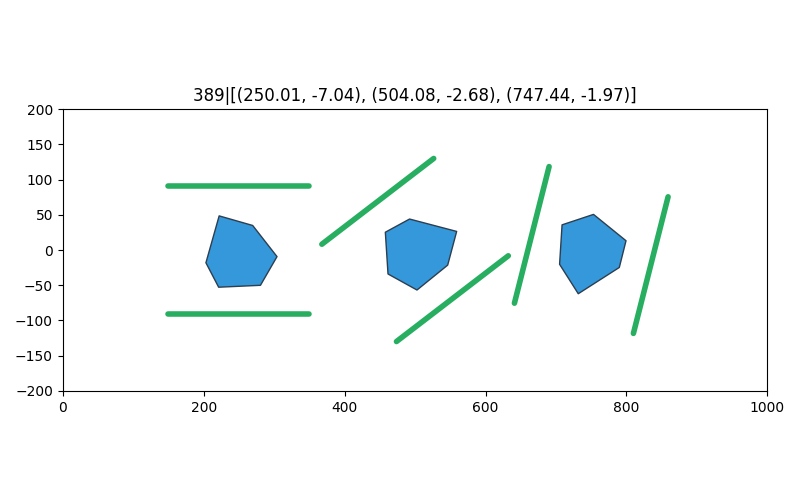

In [94]:
d = Display(points, plan)
anim = d.make_animation(10000)
plt.show()
# HTML(anim.to_html5_video())

In [ ]:
d = Display(points, plan)
anim = d.make_animation(10000)
HTML(anim.to_html5_video())

In [ ]:
query = ''
for x in points[:, 0]:
    query = query + f'x={x}&'
    
for y in points[:, 1]:
    query = query + f'y={y}&'
    
query

In [160]:
def make_radius_function(points):
    """Returns the radius function for a convex polygon. 
    
    Return format is a list of tuples. Each tuple describes a
    subfunction and the interval for which it is valid. All
    subfunctions are sinosoids."""
    
    C_x, C_y = centroid(points)
    pieces = []
    for i in range(len(points)):
        p = points[i]
        next_p = points[(i+1) % len(points)]
        
        x, y = next_p-p
        max_angle = np.arctan2(y, x) % (2*np.pi)
        
        l = p - (C_x, C_y)
        orth_angle = (np.arctan2(*reversed(l)) + np.pi/2) % (2*np.pi)
        
        dist = np.linalg.norm(l)
        
        pieces.append((max_angle, dist, orth_angle))
        
    pieces.sort(key=lambda p: p[0])
    
    piecewise_func = []
    for i in range(len(pieces)):
        min_ = pieces[(i-1) % len(pieces)][0]
        max_ = pieces[i][0]
        if max_ < min_:
            # wrapped around
            piecewise_func.append((min_, 2*np.pi) + pieces[i][1:])
            piecewise_func.append((0, max_) + pieces[i][1:])
        else:
            piecewise_func.append((min_, max_) + pieces[i][1:])
    
    piecewise_func = sorted([p for p in piecewise_func if not np.isclose(p[0], p[1])], key=lambda x: x[0])
    
    def radius_func(theta):
        theta = theta % (2*np.pi)
        for p in piecewise_func:
            min_, max_, l, i = p
            if min_ <= theta < max_:
                return l * np.abs(np.cos(theta-i))
        
    return np.array(piecewise_func), radius_func

<IPython.core.display.Javascript object>


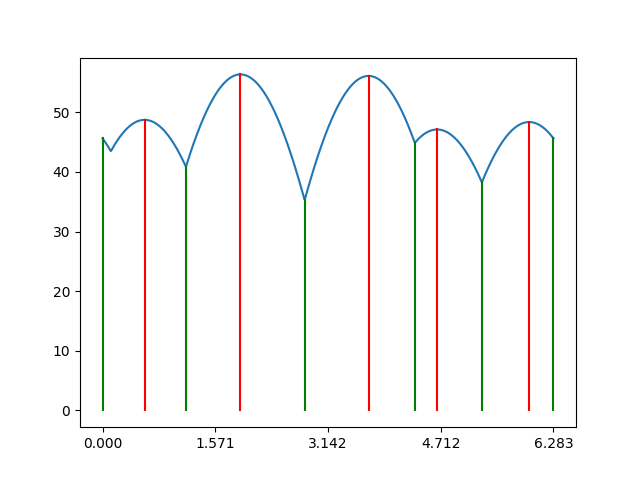

In [162]:
ch2 = np.array([[-47,   3],
       [-16, -45],
       [ 27, -40],
       [ 53,  20],
       [-30,  48]], dtype=np.int32)

piecewise_radius_func, radius_func = make_radius_function(ch2)

x = np.linspace(0, 2*np.pi, 1000)
y = np.array([radius_func(i) for i in x])

plt.figure()
plt.plot(x, y)
# plt.xticks(np.linspace(0, 4*np.pi, 9))
plt.xticks(np.linspace(0, 2*np.pi, 5))

maxima = []
for p in piecewise_radius_func:
    min_, max_, l, i = p
    if min_ <= i < max_:
        maxima.append(i)
maxima.sort()
ranges = [0] + maxima + [2*np.pi]

minima = []
discont = piecewise_radius_func[:, :2].flatten()
for i in range(len(ranges)-1):
    valid_points = discont[np.logical_and(ranges[i] <= discont, discont <= ranges[i+1])]
    minimum = min(valid_points, key=diameter_func)

    minima.append(minimum)

for m in maxima:
    plt.plot([m, m], [0, radius_func(m)], color='r')
for m in minima:
    plt.plot([m, m], [0, radius_func(m)], color='g')
    
plt.show()

In [ ]:
def radius_squeeze_func(theta):
    theta = theta % (2*np.pi)
    for i in range(len(ranges)-1):
        if ranges[i] <= theta < ranges[i+1]:
            assert ranges[i] <= minima[i] <= ranges[i+1]
            return minima[i]

    return 2*np.pi

x = np.linspace(0, 2*np.pi, 1000)
y = np.array([radius_squeeze_func(t) for t in x])

plt.figure()
plt.plot(x, y)
plt.xticks(np.linspace(0, 2*np.pi, 5))
plt.yticks(np.linspace(0, 2*np.pi, 5))
plt.show()

In [ ]:
x = np.linspace(0, 2*np.pi, 1000)
# y = np.array([radius_squeeze_func(squeeze_func(t)) for t in x])
y = np.array([radius_squeeze_func(squeeze_func(t)) for t in x])

plt.figure()
plt.plot(x, y)
plt.xticks(np.linspace(0, 2*np.pi, 5))
plt.yticks(np.linspace(0, 2*np.pi, 5))
plt.show()